In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [136]:
# 데이터 로드
file = '../data_final/KNNIM_Train_data.csv'
data = pd.read_csv(file)

In [137]:
# scale_pv가 2 이하인 데이터를 NaN으로 대체
data_imputed = data.copy()
data_imputed.loc[data_imputed['scale_pv'] <= 2, 'scale_pv'] = np.nan

In [138]:
# KNN Imputer 적용
imputer = KNNImputer(n_neighbors=5) # 5-> 100 -> 4 -> 5(Random Forest 기준 n_neighbors : 5->100시 동일, ->4시 0.0000000000000002 증가)
data_imputed[['scale_pv']] = imputer.fit_transform(data_imputed[['scale_pv']])

In [ ]:
# 예측된 scale_pv 값을 2초과 4미만 범위로 조정
data_imputed['scale_pv'] = np.clip(data_imputed['scale_pv'], 2.01, 3.99)

In [ ]:
# 중복값 제거
data_imputed.drop_duplicates(inplace=True)

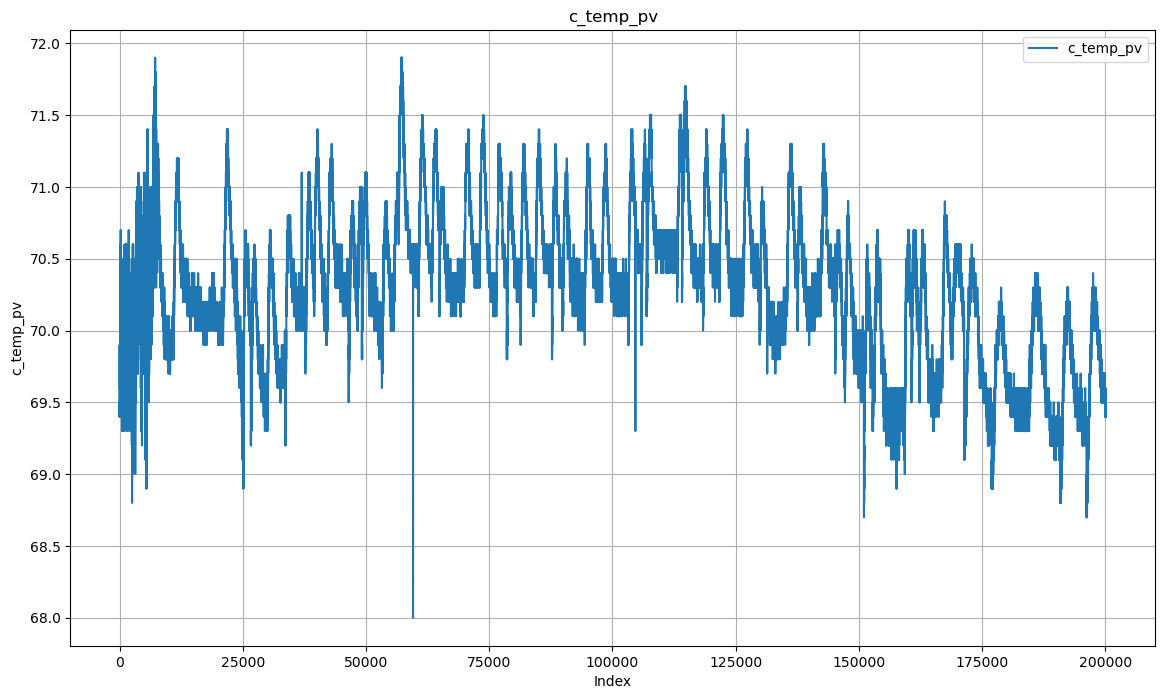

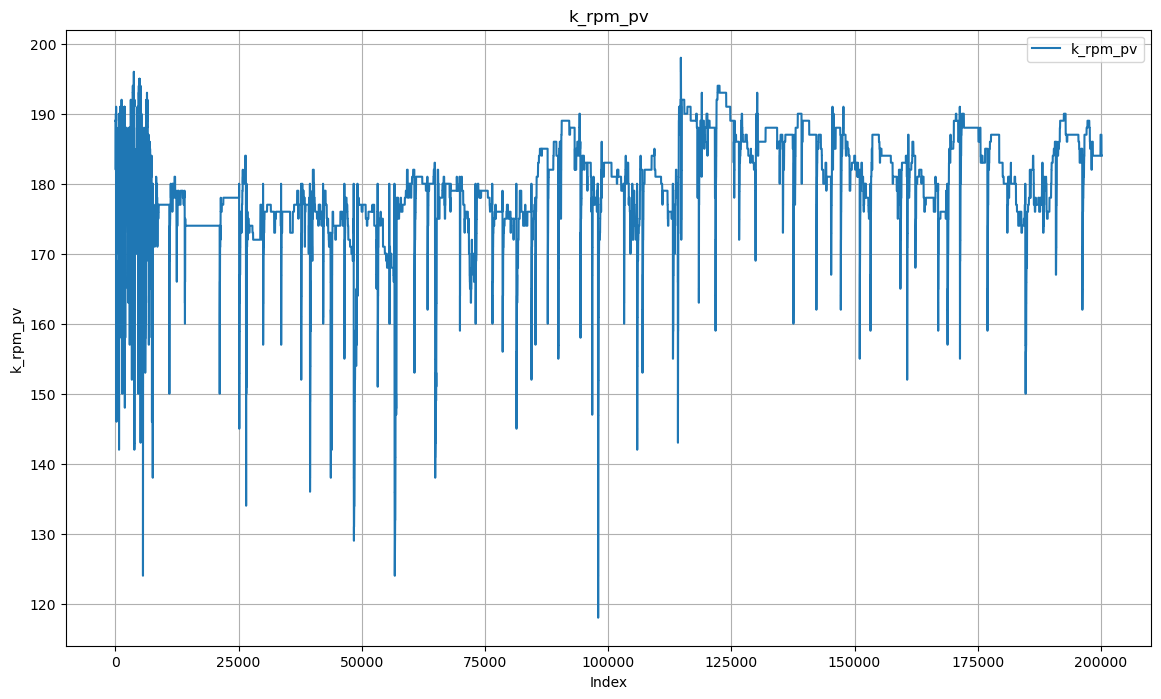

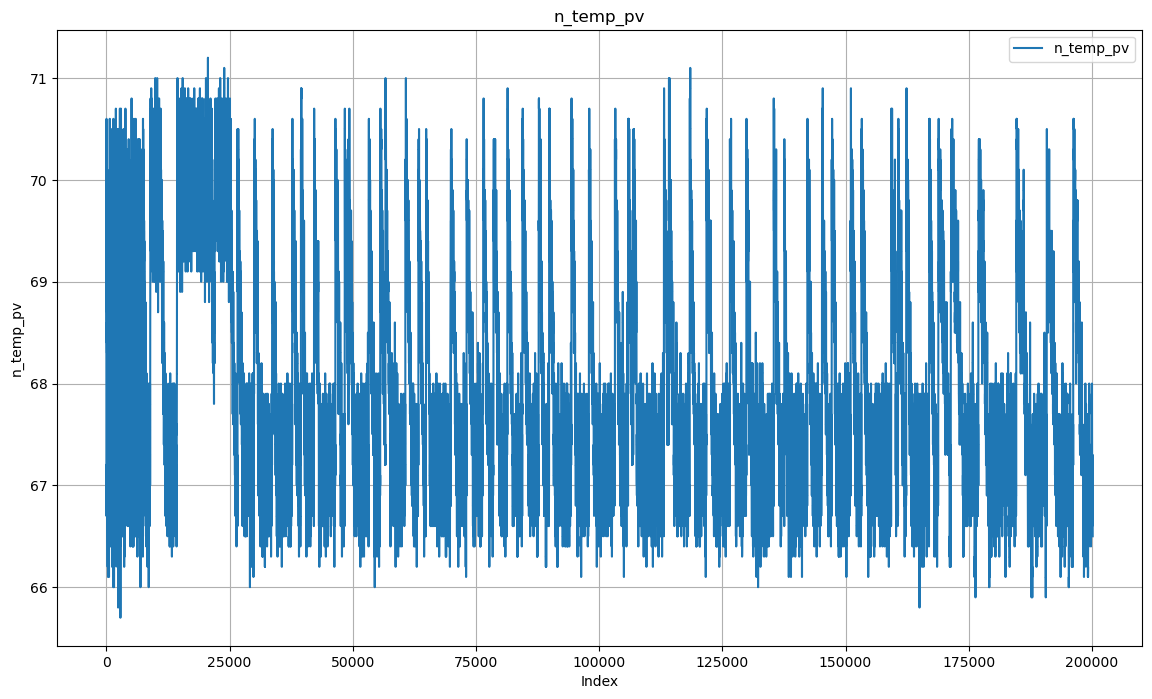

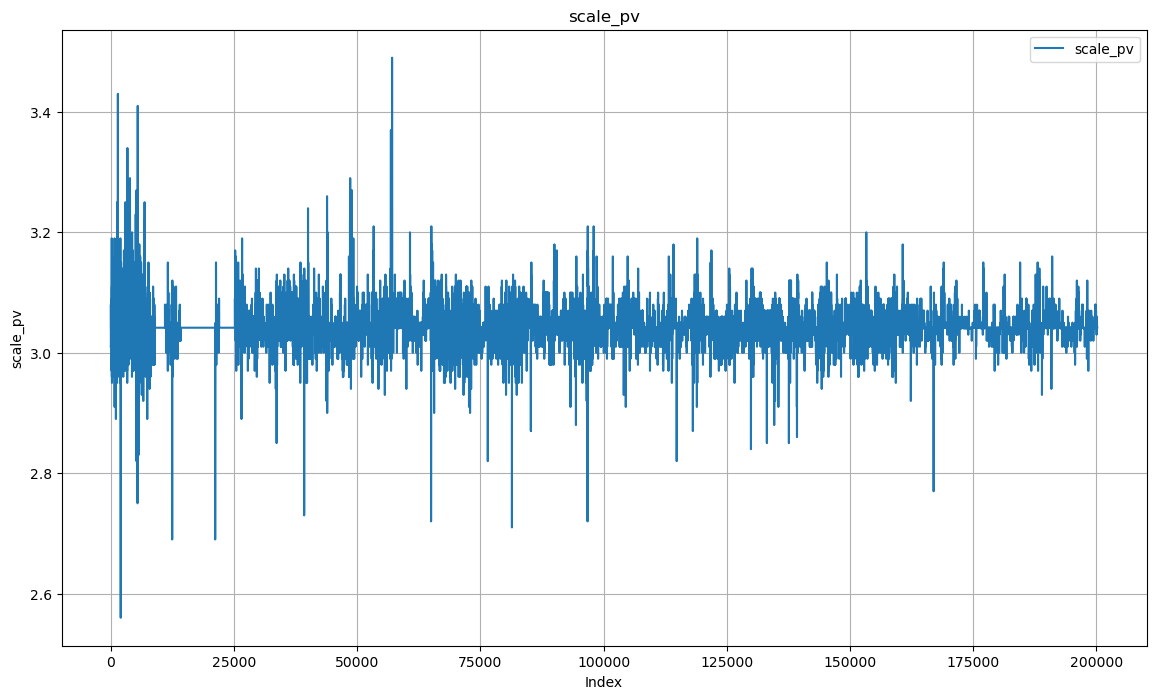

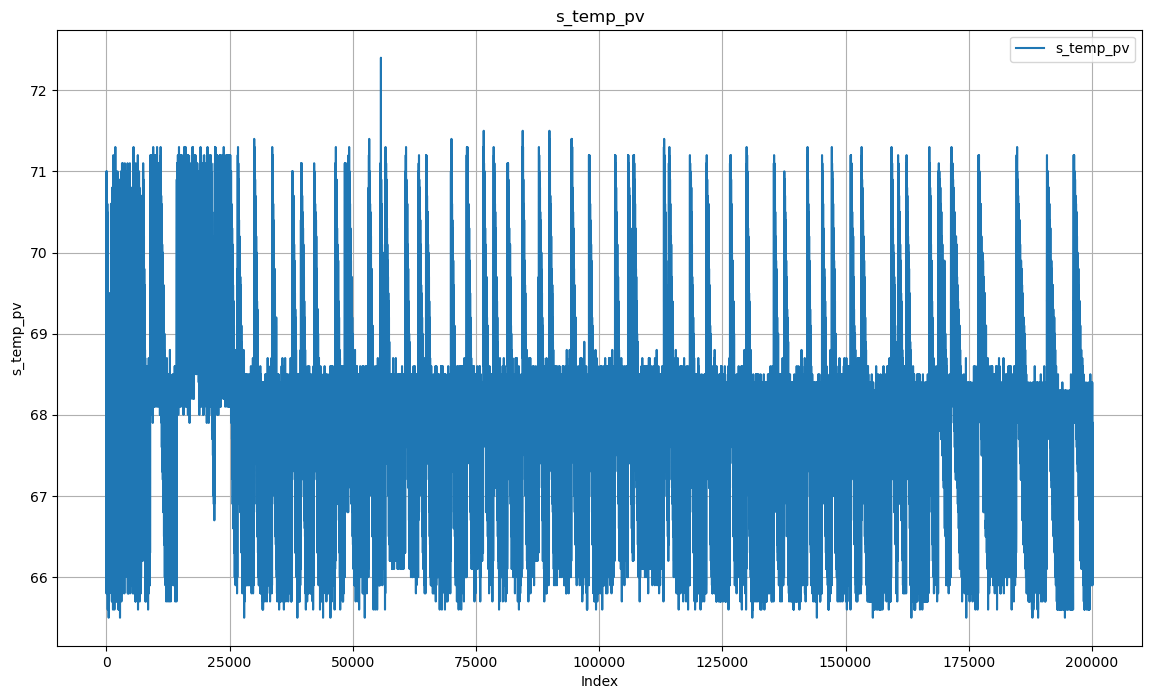

In [ ]:
# 각 컬럼별 그래프 그리기 (Imputed 데이터)
for column in data_imputed.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(data_imputed.index, data_imputed[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# 피처와 타겟 분리
X = data_imputed.drop(columns=['scale_pv'])
y = data_imputed['scale_pv']

In [ ]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
# 타겟 스케일링
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1))

In [ ]:
# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, X_train, X_valid, y_train_scaled, y_valid_scaled, target_scaler):
    model.fit(X_train, y_train_scaled.ravel())
    y_train_pred_scaled = model.predict(X_train)
    y_valid_pred_scaled = model.predict(X_valid)

    # 역스케일링
    y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
    y_valid_pred = target_scaler.inverse_transform(y_valid_pred_scaled.reshape(-1, 1))
    y_train_original = target_scaler.inverse_transform(y_train_scaled)
    y_valid_original = target_scaler.inverse_transform(y_valid_scaled)

    train_mae = mean_absolute_error(y_train_original, y_train_pred)
    valid_mae = mean_absolute_error(y_valid_original, y_valid_pred)
    train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred)
    valid_mape = mean_absolute_percentage_error(y_valid_original, y_valid_pred)

    return train_mae, valid_mae, train_mape, valid_mape, y_train_pred, y_valid_pred

In [ ]:
# 모델 학습 및 평가

# Multiple Regression
lr_model = LinearRegression()
lr_train_mae, lr_valid_mae, lr_train_mape, lr_valid_mape, lr_y_train_pred, lr_y_valid_pred = train_and_evaluate_model(lr_model, X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled, target_scaler)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_train_mae, rf_valid_mae, rf_train_mape, rf_valid_mape, rf_y_train_pred, rf_y_valid_pred = train_and_evaluate_model(rf_model, X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled, target_scaler)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_train_mae, lgb_valid_mae, lgb_train_mape, lgb_valid_mape, lgb_y_train_pred, lgb_y_valid_pred = train_and_evaluate_model(lgb_model, X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled, target_scaler)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 107248, number of used features: 4
[LightGBM] [Info] Start training from score 0.000000


In [ ]:
# 결과 출력
print(f"Linear Regression - Train MAE: {lr_train_mae}, Train MAPE: {lr_train_mape*100}")
print(f"Linear Regression - valid MAE: {lr_valid_mae}, valid MAPE: {lr_valid_mape*100}")
print()
print(f"Random Forest - Train MAE: {rf_train_mae}, Train MAPE: {rf_train_mape*100}")
print(f"Random Forest - valid MAE: {rf_valid_mae}, valid MAPE: {rf_valid_mape*100}")
print()
print(f"LightGBM - Train MAE: {lgb_train_mae}, Train MAPE: {lgb_train_mape*100}")
print(f"LightGBM - valid MAE: {lgb_valid_mae}, valid MAPE: {lgb_valid_mape*100}")

Linear Regression - Train MAE: 0.007475066865714355, Train MAPE: 0.2460376958476773
Linear Regression - valid MAE: 0.0077121810477878885, valid MAPE: 0.2537826629304128

Random Forest - Train MAE: 0.004774615358362668, Train MAPE: 0.15708299452313468
Random Forest - valid MAE: 0.010018626362336927, valid MAPE: 0.3294290224776253

LightGBM - Train MAE: 0.00741561623888665, Train MAPE: 0.2439448167894635
LightGBM - valid MAE: 0.007765625025388535, valid MAPE: 0.2553352029430549


In [ ]:
# 테스트 데이터 로드 및 필터링
test_file = '../data_final/Test_data.csv'
test_data = pd.read_csv(test_file)
test_data_filtered = test_data[(test_data['scale_pv'] > 2) & (test_data['scale_pv'] < 4)]

In [ ]:
# 피처와 타겟 분리
X_test_final = test_data_filtered.drop(columns=['scale_pv'])
y_test_final = test_data_filtered['scale_pv']

In [ ]:
# 테스트 데이터 스케일링
X_test_final_scaled = scaler.transform(X_test_final)
y_test_final_scaled = target_scaler.transform(y_test_final.values.reshape(-1, 1))

In [ ]:
# 최종 테스트 데이터 예측 및 평가
def final_evaluate_model(model, X_test, y_test_scaled, target_scaler):
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_test_original = target_scaler.inverse_transform(y_test_scaled)
    
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return test_mae, test_mape, y_test_pred

In [ ]:
# 최종 평가 결과
lr_test_mae_final, lr_test_mape_final, lr_y_test_pred_final = final_evaluate_model(lr_model, X_test_final_scaled, y_test_final_scaled, target_scaler)
rf_test_mae_final, rf_test_mape_final, rf_y_test_pred_final = final_evaluate_model(rf_model, X_test_final_scaled, y_test_final_scaled, target_scaler)
lgb_test_mae_final, lgb_test_mape_final, lgb_y_test_pred_final = final_evaluate_model(lgb_model, X_test_final_scaled, y_test_final_scaled, target_scaler)

print(f"Final Test - Linear Regression MAE: {lr_test_mae_final}, MAPE: {lr_test_mape_final*100}")
print(f"Final Test - Random Forest MAE: {rf_test_mae_final}, MAPE: {rf_test_mape_final*100}")
print(f"Final Test - LightGBM MAE: {lgb_test_mae_final}, MAPE: {lgb_test_mape_final*100}")

Final Test - Linear Regression MAE: 0.023367433775117522, MAPE: 0.7633454287742798
Final Test - Random Forest MAE: 0.026173229484099166, MAPE: 0.8564501221621741
Final Test - LightGBM MAE: 0.023943233030470003, MAPE: 0.7825402649786406
